# Running epidemic simulations under `epyc`

This notebook contains the code we developed when starting ro run `epydemic`-based netrwork simulations using the extra features of `epyc`. Specifically, we want to use `epyc` to automate running several simulations in one run; to collect the results; and to generate a plot of these results using `pandas` and `matplotlib`.

We assume some familiarity with[`pandas`](https://pandas.pydata.org/docs/) and [`matplotlib`](https://matplotlib.org/stable/index.html), but most of the code should hopefully be fairly self-explanatory. There are some links to additional material (especially on `matplotlib`) in the reading list.

In [1]:
# numpoy
import numpy

# data handling
import pandas
from pathlib import Path
datasets = Path("../../datasets")
datasets.mkdir(parents=True, exist_ok=True)

# simulation
from epyc import Experiment, Lab, JSONLabNotebook
from epydemic import ERNetwork, SIR, StochasticDynamics

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

For simplicity we'll again run an SIR simulation over an ER network &ndash; but instead of running it at *one* point in the space of parameters we;'ll run it at *several* automatically, and collect all the results.

## Creating  the notebook and lab

We first need a lab notebook in which to storee our results. We could use an in-memory notebook, buty since we generally want to retain the results of experiments we'll instead use one that's bascked by a JSON file. These are portable and easily prtocessed in a number of languages should the need arise.

In [2]:
# create a lab notebook backed by a JSON file
nb = JSONLabNotebook(Path(datasets, "06-05-sir-seq.json"), create=True)

The lab co-ordinates running experiments. We'll start here using a normal sequential lab that runs experiments one after the other.

In [3]:
# create a local, sequential lab
lab = Lab(notebook=nb)

## Setting the parameter space

We now need to set the parameter space for the experiments we want to perform.

When we ran single simulations, we put a parameter set into a dict and passed it to the experiment to use. When running in a lab we can instead set up a parameter space that's like a parameter set but can have some (or all) of the names mapped to *sequences* of values. When it runs an experiment in this space, the lab will creatre individual parameter sets from this space, by default creating one parameter set for every combination of values we can draw from the sequences.

In [4]:
# set the disease paramerter space
lab[SIR.P_INFECTED] = 0.01
lab[SIR.P_INFECT] = numpy.linspace(0.0, 1.0,
                                   num=20)
lab[SIR.P_REMOVE] = 0.002

We also need to topological parameters for the network we're going to run on.

In [5]:
# set the topology for the generated network
lab[ERNetwork.N] = int(1e4)
lab[ERNetwork.KMEAN] = 5

You might have noticed these are slightly different topological parameters than we used before, describing a smaller, less connected network. This is for speed, because we'll be doing 20 experiments instead of 1. Feel free to change them around to try against different networks and structures.

## Running the experiments

Before wqe run the experiments, we'll create a result set to hold the results. This isn't strictly necvessary &ndash; the notebook has a default result set &ndash; but it's good practice and can save confusion later.

In [6]:
# add a result set
nb.addResultSet("sir-first",
                "First SIR runs")

We can now build the experiment, exactly as we did for the single-run case, bu combining a proicess, a network generator, and a simulation dynamics.

In [7]:
# build the experiment
p = SIR()
g = ERNetwork()
e = StochasticDynamics(p, g)

If you're curious as to what experiments will be run at which parameter sets, we can extract the *experimental configuration* that describes the experiments the lab will perform.

In [8]:
lab.experiments(e)

[(<epydemic.stochasticdynamics.StochasticDynamics at 0x7f7e3b147490>,
  {'epydemic.sir.pInfected': 0.01,
   'epydemic.sir.pInfect': 0.15789473684210525,
   'epydemic.sir.pRemove': 0.002,
   'N': 10000,
   'kmean': 5}),
 (<epydemic.stochasticdynamics.StochasticDynamics at 0x7f7e3b147490>,
  {'epydemic.sir.pInfected': 0.01,
   'epydemic.sir.pInfect': 0.6842105263157894,
   'epydemic.sir.pRemove': 0.002,
   'N': 10000,
   'kmean': 5}),
 (<epydemic.stochasticdynamics.StochasticDynamics at 0x7f7e3b147490>,
  {'epydemic.sir.pInfected': 0.01,
   'epydemic.sir.pInfect': 0.0,
   'epydemic.sir.pRemove': 0.002,
   'N': 10000,
   'kmean': 5}),
 (<epydemic.stochasticdynamics.StochasticDynamics at 0x7f7e3b147490>,
  {'epydemic.sir.pInfected': 0.01,
   'epydemic.sir.pInfect': 0.631578947368421,
   'epydemic.sir.pRemove': 0.002,
   'N': 10000,
   'kmean': 5}),
 (<epydemic.stochasticdynamics.StochasticDynamics at 0x7f7e3b147490>,
  {'epydemic.sir.pInfected': 0.01,
   'epydemic.sir.pInfect': 0.578947368

You can see here that each parameter set differs by having a different point taken from the space of `P_INFECT` values we specified for the parametrer space.

We can now run the experiments.

In [9]:
# run the experiment
lab.runExperiment(e)

The results that come back aren't immediately returned, but instead are stored in the notebook and saved to disc in JSON. We can extract the results in several ways, including as a list resuilts dicts, which can be useful when you want to run the same analysis code that you might have used on a single run. When dealing with lots of results, however, it's often better to retrieve the results as a `pandas` dataframe.

In [10]:
# retrieve the dataframe of results
df = nb.dataframe()

In [11]:
df

,epyc.experiment.classname,epyc.experiment.elapsed_time,epyc.experiment.end_time,epyc.experiment.exception,epyc.experiment.experiment_time,epyc.experiment.setup_time,epyc.experiment.start_time,epyc.experiment.status,epyc.experiment.teardown_time,epyc.experiment.traceback,...,epydemic.monitor.time,N,epydemic.sir.pInfect,epydemic.sir.pInfected,epydemic.sir.pRemove,kmean,topology,epydemic.sir.I,epydemic.sir.R,epydemic.sir.S
0,epydemic.stochasticdynamics.StochasticDynamics,1.523089,2023-07-13 10:30:09.245865,,1.382929,0.140151,2023-07-13 10:30:07.722776,True,0.000009,,...,4328.763246,10000,0.210526,0.01,0.002,5,ER,0,9911,89
1,epydemic.stochasticdynamics.StochasticDynamics,1.518719,2023-07-13 10:30:10.766827,,1.414259,0.104450,2023-07-13 10:30:09.248108,True,0.000010,,...,4718.438151,10000,0.842105,0.01,0.002,5,ER,0,9928,72
2,epydemic.stochasticdynamics.StochasticDynamics,1.484212,2023-07-13 10:30:12.304505,,1.384218,0.099984,2023-07-13 10:30:10.820293,True,0.000010,,...,5398.771511,10000,0.105263,0.01,0.002,5,ER,0,9917,83
3,epydemic.stochasticdynamics.StochasticDynamics,1.551810,2023-07-13 10:30:13.858460,,1.445354,0.106446,2023-07-13 10:30:12.306650,True,0.000010,,...,5381.635382,10000,0.631579,0.01,0.002,5,ER,0,9943,57
4,epydemic.stochasticdynamics.StochasticDynamics,1.479823,2023-07-13 10:30:15.340346,,1.376652,0.103162,2023-07-13 10:30:13.860523,True,0.000009,,...,5187.252617,10000,0.789474,0.01,0.002,5,ER,0,9926,74
5,epydemic.stochasticdynamics.StochasticDynamics,1.510909,2023-07-13 10:30:16.853295,,1.407674,0.103226,2023-07-13 10:30:15.342386,True,0.000009,,...,5009.867448,10000,0.368421,0.01,0.002,5,ER,0,9911,89
6,epydemic.stochasticdynamics.StochasticDynamics,1.549001,2023-07-13 10:30:18.404342,,1.380318,0.168673,2023-07-13 10:30:16.855341,True,0.000010,,...,4661.965104,10000,1.000000,0.01,0.002,5,ER,0,9921,79
7,epydemic.stochasticdynamics.StochasticDynamics,1.466012,2023-07-13 10:30:19.872608,,1.369176,0.096824,2023-07-13 10:30:18.406596,True,0.000012,,...,4440.254737,10000,0.421053,0.01,0.002,5,ER,0,9924,76
8,epydemic.stochasticdynamics.StochasticDynamics,1.542611,2023-07-13 10:30:21.417344,,1.441596,0.101007,2023-07-13 10:30:19.874733,True,0.000008,,...,5835.775768,10000,0.526316,0.01,0.002,5,ER,0,9938,62
9,epydemic.stochasticdynamics.StochasticDynamics,1.489303,2023-07-13 10:30:22.908641,,1.392746,0.096549,2023-07-13 10:30:21.419338,True,0.000008,,...,5106.645657,10000,0.157895,0.01,0.002,5,ER,0,9941,59


How long did it take to run the simulations? That's where the experimental metadata comes in. Each experiment (row) has a metadata entry (column) specifying the start and end times (as well as other things). We can use these to interrogate the simulations and extract the totral elapsed time.

In [12]:
print("Total elapsed time {dt:.0f}s".format(dt=(df[Experiment.END_TIME].max() - df[Experiment.END_TIME].min()).total_seconds()))

Total elapsed time 28s


## Plotting results

We can now use the dataframe to plot some results. `matplotlib` and `pandas` are designed to work together, so we can create a plot directly from the simulation results.

Let's plot the final size of the Susceptible compartment at the end of each simulation. This tells us how many individuals *weren't* infected as a result of the outbreak for a given value of $p_{infect}$. 

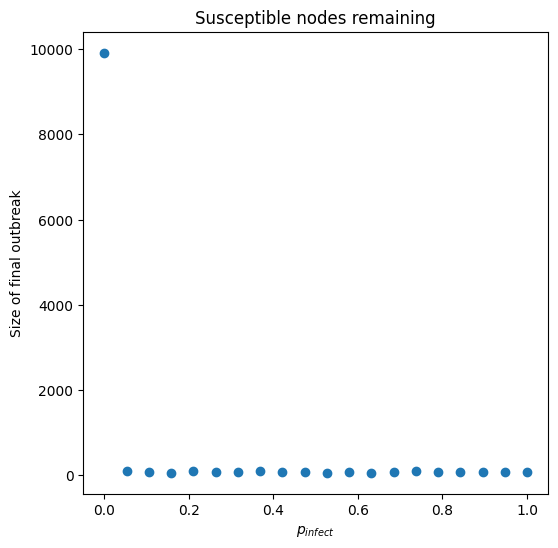

In [13]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# plot the size of the Susceptible compartment remaining at the end
ax.scatter(df[SIR.P_INFECT], df[SIR.SUSCEPTIBLE])

# fill in the title and axis labels
ax.set_title('Susceptible nodes remaining')
ax.set_xlabel('$p_{infect}$')
ax.set_ylabel('Size of final outbreak')
plt.show()

Hmmmm... not all that informative. Looking at the plot, the problem is that the value of the first point is huge compared to the others. This corresponds to $p_{infect} = 0$, no infection &ndash; and so there will have been no infections at all.

Perhaps we can get more information by dropping this unusually large value. We can do this by using boolean indexing on the dataframe, retaining all the elements for which `df[SIR.P_INFECT] > 0.0`.

In [14]:
# drop the point corresponding to P_INFECT = 0
df1 = df[df[SIR.P_INFECT] > 0.0]

There are two things to notice here. Firstly, we've created a *new* dataframe from the existing one, thereby leaving the original raw data unchanged. Thius is a general feature of `pandas`: most of the available functions copy the data rather than changing it. (`pandas` is smart enough not to *actually* copy the data, though, so its operatioons don't use huge amounts of memory.)

Secondly, we specified the data wrangling we wanted to do as code, rather than manipulating the data by hand. That means the change of both documented anmd reproducible when applied to the dataset.

We can now plot the data and see what we get.

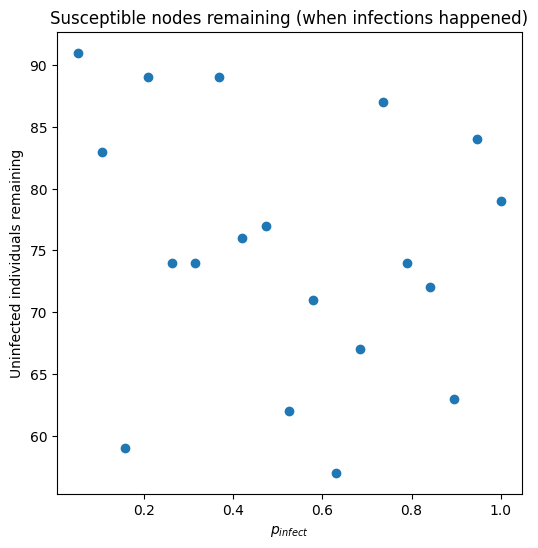

In [15]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# plot the size of the Susceptible compartment remaining at the end
ax.scatter(df1[SIR.P_INFECT], df1[SIR.SUSCEPTIBLE])

# fill in the title and axis labels
ax.set_title('Susceptible nodes remaining (when infections happened)')
ax.set_xlabel('$p_{infect}$')
ax.set_ylabel('Uninfected individuals remaining')
plt.show()

No pattern. Is that surprising? The numbers aren't changing very much, so there's not huge variation. But it doesn't change smoothly with $p_{infect}$, suggesting that there might be some random influence in play. Of course we only ran a single simulation for each paramreter set, so it wouldn't perhaps be surpring if we saw random fluctuations. If we want to eliminate them, though, we'd need to do a lot more simuation.